<a href="https://colab.research.google.com/github/fnbellomo/DiploDatos2021/blob/main/AyVD/Entregable_Parte_1_Natan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Trabajo práctico entregable - Parte 1

In [50]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
import scipy
import scipy.cluster.hierarchy as sch

seaborn.set_context('talk')

## Lectura del dataset

En la notebook 00 se explican los detalles de la siguiente sección.

In [51]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/sysarmy_survey_2020_processed.csv'
df = pd.read_csv(url)

In [52]:
df[:3]

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.00,3.00,3.00,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.00,Bruto,Full-Time,53000.00,43000.00,NaN,1,1,No,No recibo bono,No,0.00,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN
1,Hombre,29,Argentina,Corrientes,5.00,2.00,2.00,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.00,Bruto,Full-Time,79000.00,63000.00,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.00,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.00,0.00,0.00,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.00,Porcentaje de mi sueldo,Full-Time,160000.00,127000.00,NaN,3,3,Un sueldo,Performance individual,No,0.00,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN


# Ejercicio 1 - Análisis descriptivo

Responder a la pregunta: **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?**

Para ello:
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en una sub-población. Por ejemplo, se pueden limitar a personas con un salario mayor que 10000 pesos, o a las personas que trabajan sólo en "Data Science", pero deben justificar su elección y reformular la pregunta inicial de ser necesario.
  * Obtener una lista de los lenguajes de programación más populares. Decidir cuántos y cuáles seleccionan para incluir en el análisis.
  * Para cada una de las otras columnas del punto anterior, elegir los rangos o valores seleccionan para incluir en el análisis.
3. Seleccionar métricas que ayuden a responder la pregunta, y los métodos para analizarlas. Elegir UNA de las siguientes opciones:
  * Comparar las distribuciones de salario para cada lenguaje utilizando visualizaciones. Como la visualización es el producto final, debe ser clara y mostrar información relevante.
  * Comparar medidas de estadística descriptiva sobre la distribución de salario para cada lenguaje. Sean creativos, la estadística descriptiva nos permite decir cosas como: "el 10% de los mejores sueldos los ganan, en su mayoría, programadores que saben kotlin!" (donde *mayoría* es un término medio engañoso que sólo significa más del 50%). Para comparar múltiples lenguajes, les recomendamos usar también visualizaciones.
  * Comparar probabilidades. Por ejemplo: "Si sabés Python o Java, tenés un 30% más de chances de ganar arriba de 100K".

Si lo consideran necesario, realicen varias iteraciones. Es decir, si encuentran que las distribuciones de los lenguajes de programación que seleccionaron inicialmente no son muy diferentes, pueden re-hacer el análisis usando sólo los lenguajes de programación que son diferentes.

In [53]:
# complete here if you want to include more columns
relevant_columns = ['tools_programming_languages', 'salary_monthly_NETO', 'salary_monthly_BRUTO']

### Conteo de frecuencias de los lenguajes de programación

La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`. Sus valores son strings con los lenguajes seleccionados separados por comas.



In [54]:
df.tools_programming_languages[:3]

0                     Ninguno
1    HTML, Javascript, Python
2                     Ninguno
Name: tools_programming_languages, dtype: object

Las siguientes celdas de código separan estos lenguajes de programación y cuentan la frecuencia con la que aparecen.

No es necesario entender este código en profundidad, aunque sí es un buen ejercicio.

In [55]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df.loc[:, 'cured_programming_languages'] = df.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,cured_programming_languages
0,ninguno,Ninguno,43000.00,53000.00,[ninguno]
1,html,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
2,ninguno,Ninguno,127000.00,160000.00,[ninguno]


En la columna `programming_language` se encuentra cada lenguaje por separado. Notar que si una respuesta contenía 3 lenguajes, como `"HTML, Javascript, Python"`, la fila ha sido replicada 3 veces. Por ello, hay tres filas con índice 1.

In [56]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count[:10]

,language,frequency
0,javascript,2513
1,sql,2154
2,html,1861
3,python,1475
4,java,1453
5,css,1247
6,bash/shell,993
7,php,891
8,.net,823
9,typescript,779


## Filtrado de lenguajes relevantes

El siguiente código permite seleccionar sólo las filas donde el valor de la columna `programming_language` se encuentre en la lista `interesting_languages`.

In [57]:
# Filter out languages that we want to exclude
# Complete here with your selected list.
interesting_languages = ["Python"]
filtered_df_lang = df_lang[df_lang.programming_language.isin(interesting_languages)]
filtered_df_lang[:5]

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,cured_programming_languages


# Ejercicio 2 - Densidades y varias varialbes

Responder a la pregunta general: **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?**

Para ello considere (igual al ejercicio Anterior):
1. Seleccionar las columnas relevantes para analizar.
2. Seleccionar las filas relevantes para analizar. Esto incluye la eliminación de valores extremos y erróneos, pero también puede enfocar el análisis en sub-poblaciones. 

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)


In [58]:
df_lang 

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,cured_programming_languages
0,ninguno,Ninguno,43000.00,53000.00,[ninguno]
1,html,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
1,javascript,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
1,python,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]"
2,ninguno,Ninguno,127000.00,160000.00,[ninguno]
...,...,...,...,...,...
6093,java,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ..."
6093,javascript,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ..."
6093,php,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ..."
6093,python,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ..."


In [59]:
df_lang['salary_monthly_porcentaje'] = df_lang['salary_monthly_NETO'] / df_lang['salary_monthly_BRUTO']
df_lang['salary_monthly_filtrados'] = (df_lang['salary_monthly_porcentaje'] >0.5) & (df_lang['salary_monthly_porcentaje'] <0.9) 
df_lang 

,programming_language,tools_programming_languages,salary_monthly_NETO,salary_monthly_BRUTO,cured_programming_languages,salary_monthly_porcentaje,salary_monthly_filtrados
0,ninguno,Ninguno,43000.00,53000.00,[ninguno],0.81,True
1,html,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]",0.80,True
1,javascript,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]",0.80,True
1,python,"HTML, Javascript, Python",63000.00,79000.00,"[html, javascript, python]",0.80,True
2,ninguno,Ninguno,127000.00,160000.00,[ninguno],0.79,True
...,...,...,...,...,...,...,...
6093,java,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ...",0.00,False
6093,javascript,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ...",0.00,False
6093,php,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ...",0.00,False
6093,python,"C, C++, HTML, Java, Javascript, PHP, Python, SQL",72.00,86000.00,"[c, c++, html, java, javascript, php, python, ...",0.00,False


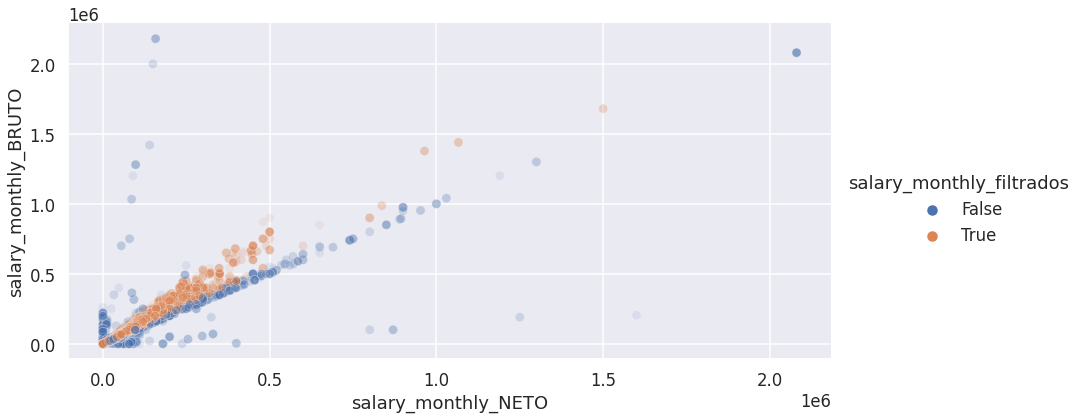

In [60]:
seaborn.pairplot(data=df_lang,
                 y_vars=['salary_monthly_BRUTO'],
                 x_vars=['salary_monthly_NETO'],
                 hue='salary_monthly_filtrados',
                 aspect=2,
                 height=6,
                 plot_kws=dict(alpha=0.1))

In [61]:
total_en_blanco = len(df_lang[df_lang['salary_monthly_filtrados']])
print('Porcentaje de población analizado: ', format(total_en_blanco / len(df_lang), '.2%'))

Porcentaje de población analizado:  80.57%


### Se toma como subpoblación de estudios a los programadores en blanco
Por esto, se sacan los datos cuya proporción de descuentos al salario bruto es menor al 10%, o mayor al 50%. La subpoblación obtenida tiene un n del 80,57% de la población original

In [62]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pivot_df = pd.pivot_table(df_lang, values='salary_monthly_NETO', index=['programming_language'],
                    aggfunc=[len, numpy.mean, numpy.std])
pivot_df.sort_values(by=('mean','salary_monthly_NETO'), ascending=False, inplace=True)
pivot_df



,len,mean,std
,salary_monthly_NETO,salary_monthly_NETO,salary_monthly_NETO
haskell,2.00,690000.00,nan
elm,1.00,690000.00,nan
hcl,2.00,414292.50,92924.44
nim,1.00,277000.00,nan
plataforma,1.00,215000.00,nan
...,...,...,...
xml.,1.00,42.00,nan
xsl,1.00,42.00,nan
android,1.00,35.00,nan


## Existen demasiado casos de lenguajes utilizados por solo 1 o 2 encuestados.
### Por ende, se limitará el análisis a los lenguajes utilizados por más de min_lang_users

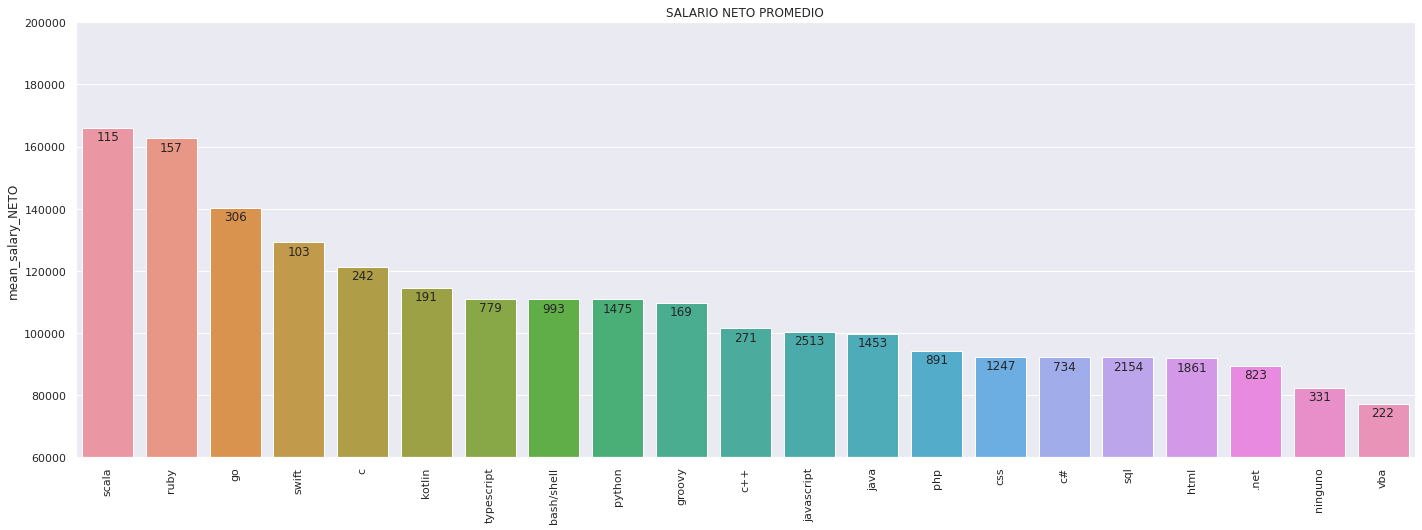

In [63]:
min_lang_users = 100
min_salary = 0000
pivot_df_filtered = pivot_df[(pivot_df[('len','salary_monthly_NETO')] > min_lang_users)]
pivot_df_filtered.columns = ['count', 'mean_salary_NETO', 'std_salary_NETO']
len(pivot_df_filtered.mean_salary_NETO)

plt.figure(figsize=(24,8))
seaborn.set_theme(style="darkgrid")
b = seaborn.barplot(data=pivot_df_filtered, x=pivot_df_filtered.index, y='mean_salary_NETO')
b.set_title('SALARIO NETO PROMEDIO')
b.set(ylim=(60000, 200000))
for item in b.get_xticklabels():
    item.set_rotation(90)

i = 0
for p in b.patches: #Agregar etiquetas cuenta
    b.annotate((format(pivot_df_filtered['count'][i], '.0f')), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -9), 
                   textcoords = 'offset points')
    i += 1


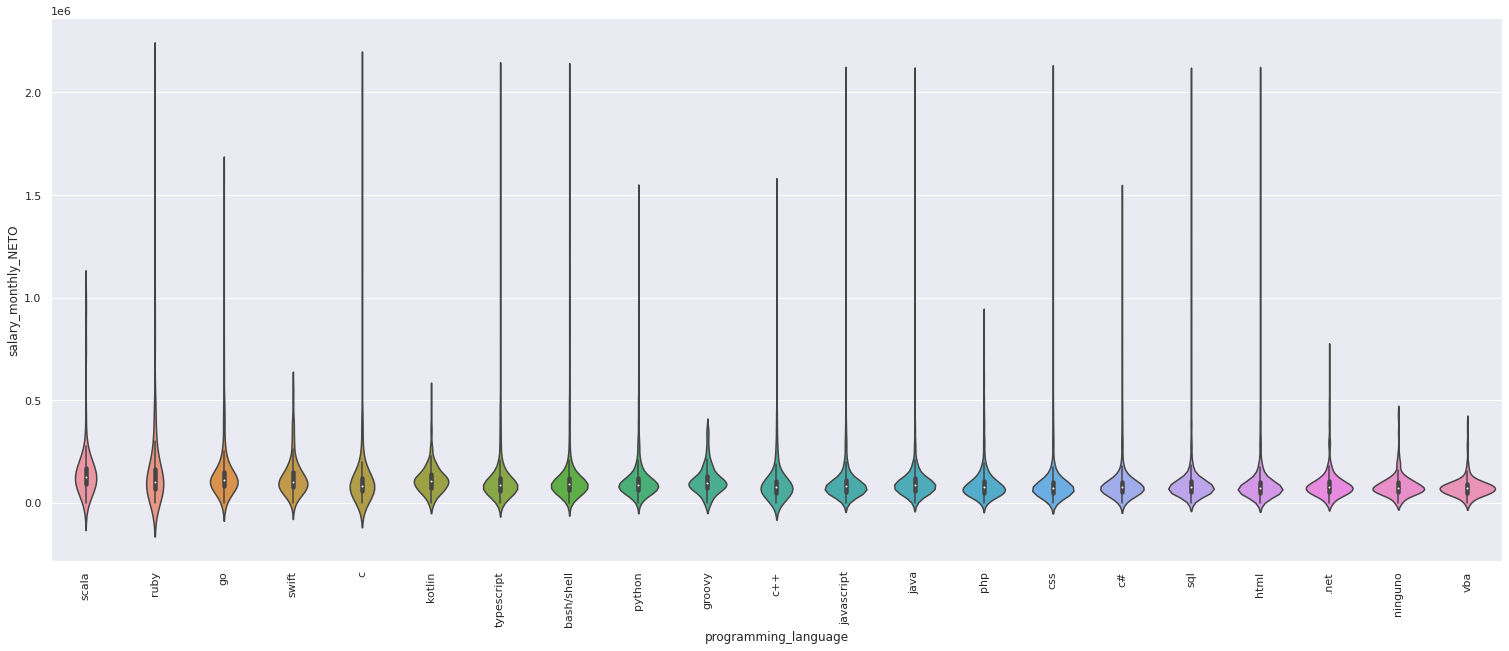

In [64]:
plt.figure(figsize=(26, 10))
v = seaborn.violinplot(x='programming_language', y='salary_monthly_NETO', 
                       data=df_lang[df_lang.programming_language.isin(pivot_df_filtered.index)], 
                       order=pivot_df_filtered.index) 
for item in v.get_xticklabels():
    item.set_rotation(90)
#v.set(ylim=(-5000, 300000))

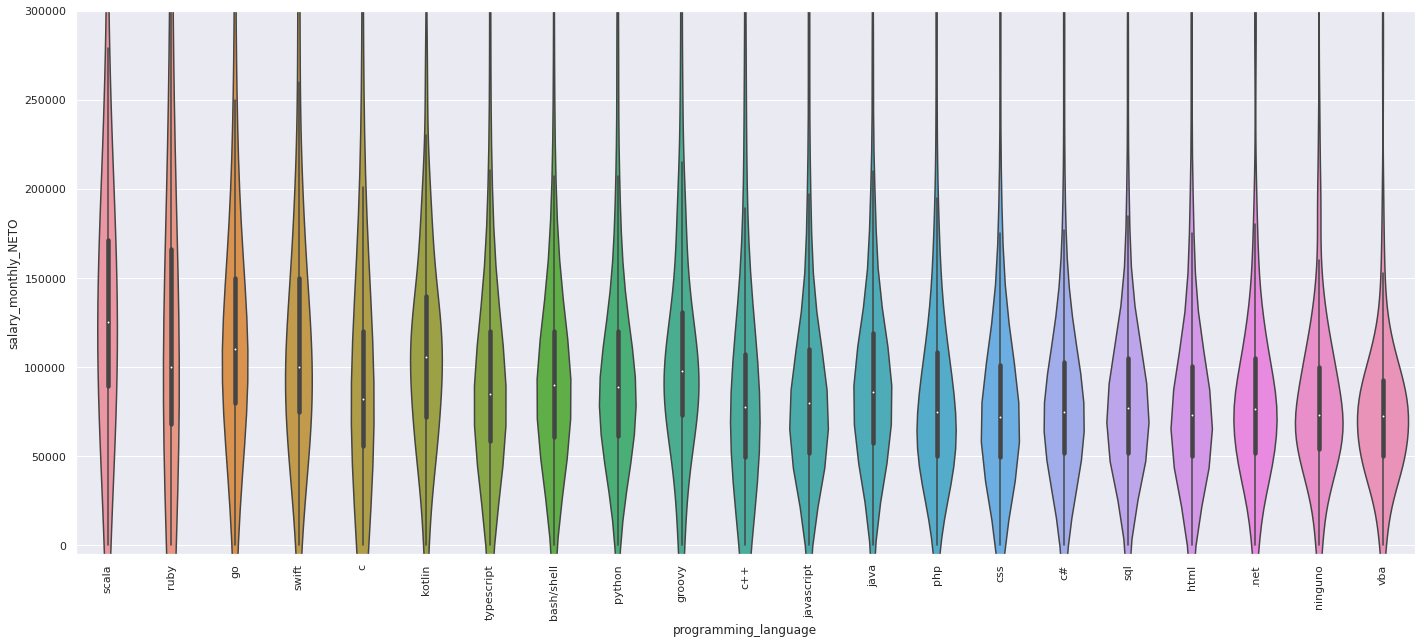

In [65]:
plt.figure(figsize=(24, 10))
v = seaborn.violinplot(x='programming_language', y='salary_monthly_NETO', 
                       data=df_lang[df_lang.programming_language.isin(pivot_df_filtered.index)], 
                       order=pivot_df_filtered.index) 
v.set(ylim=(-5000, 300000))
for item in v.get_xticklabels():
    item.set_rotation(90)

Text(0.5, 1.0, 'RELACIÓN ENTRE CANTIDAD DE PROGRAMADORES QUE CONOCEN UN LENGUAJE Y EL SALARIO PROMEDIO DE ESE LENGUAJE')

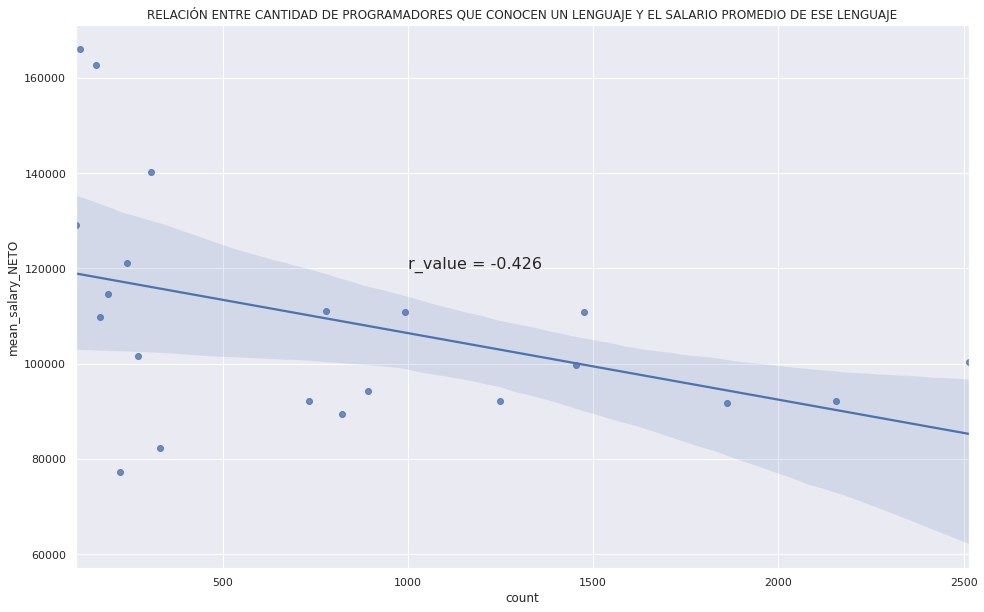

In [66]:
plt.figure(figsize=(16, 10))
r = seaborn.regplot(x='count', y='mean_salary_NETO', data=pivot_df_filtered)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pivot_df_filtered['count'],pivot_df_filtered['mean_salary_NETO'])
r.annotate('r_value = ' + str(format(r_value,'.3f')), (1000,120000), fontsize=16)
r.set_title('RELACIÓN ENTRE CANTIDAD DE PROGRAMADORES QUE CONOCEN UN LENGUAJE Y EL SALARIO PROMEDIO DE ESE LENGUAJE')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'SALARIO NETO PROMEDIO DE PROGRAMADORES QUE CONOCEN len_langs CANTIDAD DE LENGUAJES')

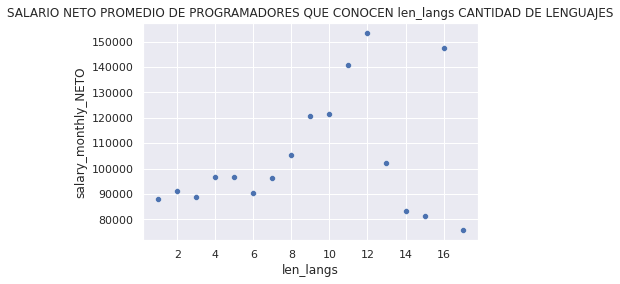

In [67]:
df
df_amount_of_langs = df[(df['tools_programming_languages'] != 'Ninguno') & (df['tools_programming_languages'] != 'Ninguno de los anteriores') & ((df['salary_monthly_NETO']/df['salary_monthly_BRUTO']) > 0.5) & ((df['salary_monthly_NETO']/df['salary_monthly_BRUTO']) < 0.85)]
df_amount_of_langs['len_langs'] = df_amount_of_langs['cured_programming_languages'].str.len()
s = seaborn.scatterplot(data = df_amount_of_langs[['len_langs','salary_monthly_NETO']].groupby(by=['len_langs']).mean().iloc[1:], x ='len_langs', y='salary_monthly_NETO')
s.set_title('SALARIO NETO PROMEDIO DE PROGRAMADORES QUE CONOCEN len_langs CANTIDAD DE LENGUAJES')

# seaborn.jointplot(data = df_amount_of_langs, x='len_langs', y='salary_monthly_NETO')


In [68]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

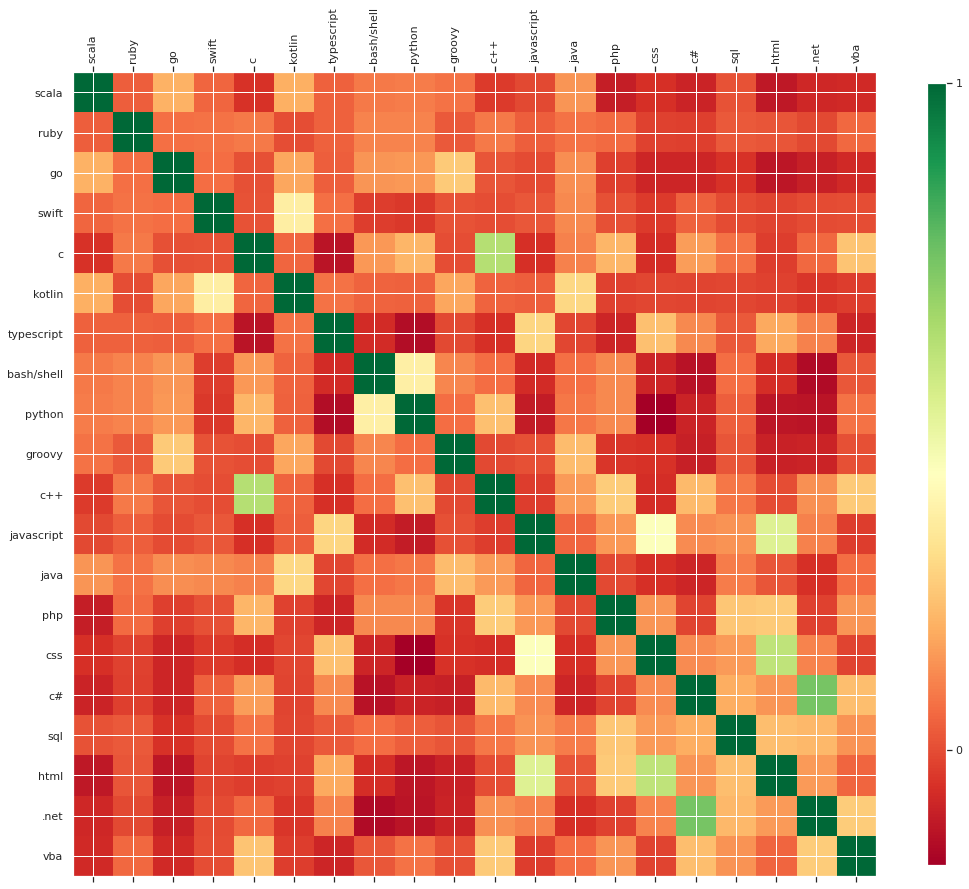

In [69]:
df_lang_booleans = df_lang.join(df_lang['cured_programming_languages'].str.join(',').str.get_dummies(sep=',').astype(bool)[pivot_df_filtered.index])
df_lang_space = df_lang_booleans.drop(['programming_language','tools_programming_languages','cured_programming_languages','salary_monthly_NETO', 'salary_monthly_BRUTO','salary_monthly_porcentaje','salary_monthly_filtrados','ninguno'], axis=1, inplace=False)
df_lang_space
# corr = df_lang_space.corr()
# corr.style.background_gradient(cmap='coolwarm')
# df_lang['cured_programming_languages'].str.join(',').str.get_dummies(sep=',').astype(bool)[pivot_df_filtered.index]
plot_corr(df_lang_space,18)

In [70]:
column_list = df_lang_space.columns.tolist()
print(column_list)
numpy.random.shuffle(column_list)
df_lang_space = df_lang_space[column_list]

['scala', 'ruby', 'go', 'swift', 'c', 'kotlin', 'typescript', 'bash/shell', 'python', 'groovy', 'c++', 'javascript', 'java', 'php', 'css', 'c#', 'sql', 'html', '.net', 'vba']


20
190
[[ 5.          6.          0.40773888  2.        ]
 [ 4.         18.          0.57485933  2.        ]
 [ 9.         12.          0.62335019  2.        ]
 [ 8.         22.          0.7438732   3.        ]
 [ 0.         16.          0.94288841  2.        ]
 [11.         17.          0.97356419  2.        ]
 [ 2.         15.          1.08734581  2.        ]
 [ 1.         25.          1.09683411  3.        ]
 [26.         27.          0.98736845  5.        ]
 [19.         28.          1.01606074  6.        ]
 [24.         29.          1.09658467  8.        ]
 [ 7.         30.          1.08607467  9.        ]
 [ 3.         21.          1.14662153  3.        ]
 [10.         32.          1.14451593  4.        ]
 [31.         33.          1.07617929 13.        ]
 [13.         34.          1.1434811  14.        ]
 [14.         23.          1.15959881  4.        ]
 [35.         36.          1.27805306 18.        ]
 [20.         37.          1.31602344 20.        ]]
['c#', '.net', 'bash/sh

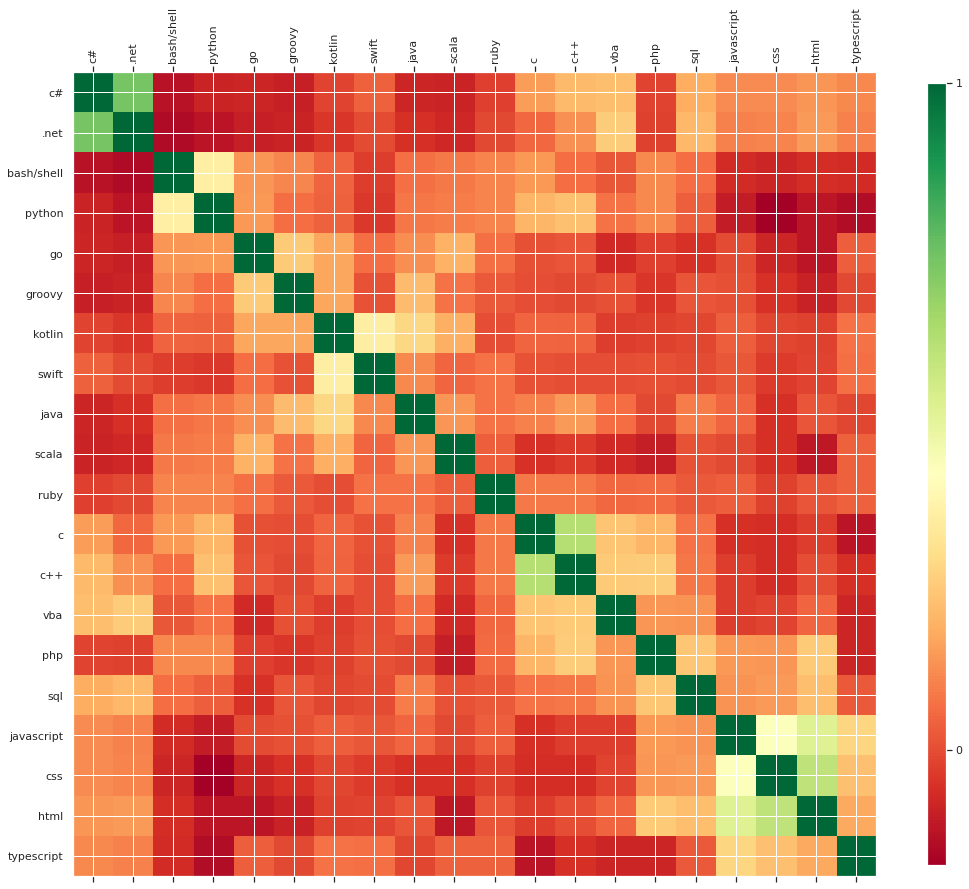

In [71]:
X = df_lang_space.corr().values
d = sch.distance.pdist(X)   # vector of ('columns' choose 2) pairwise distances
print(len(X))
print(len(d))
L = sch.linkage(d, method='centroid')
print(L)
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df_lang_space.columns.tolist()[i] for i in list((numpy.argsort(ind)))]
print(columns)
df_lang_space = df_lang_space.reindex(columns, axis=1)
print(ind)
plot_corr(df_lang_space, size=18)


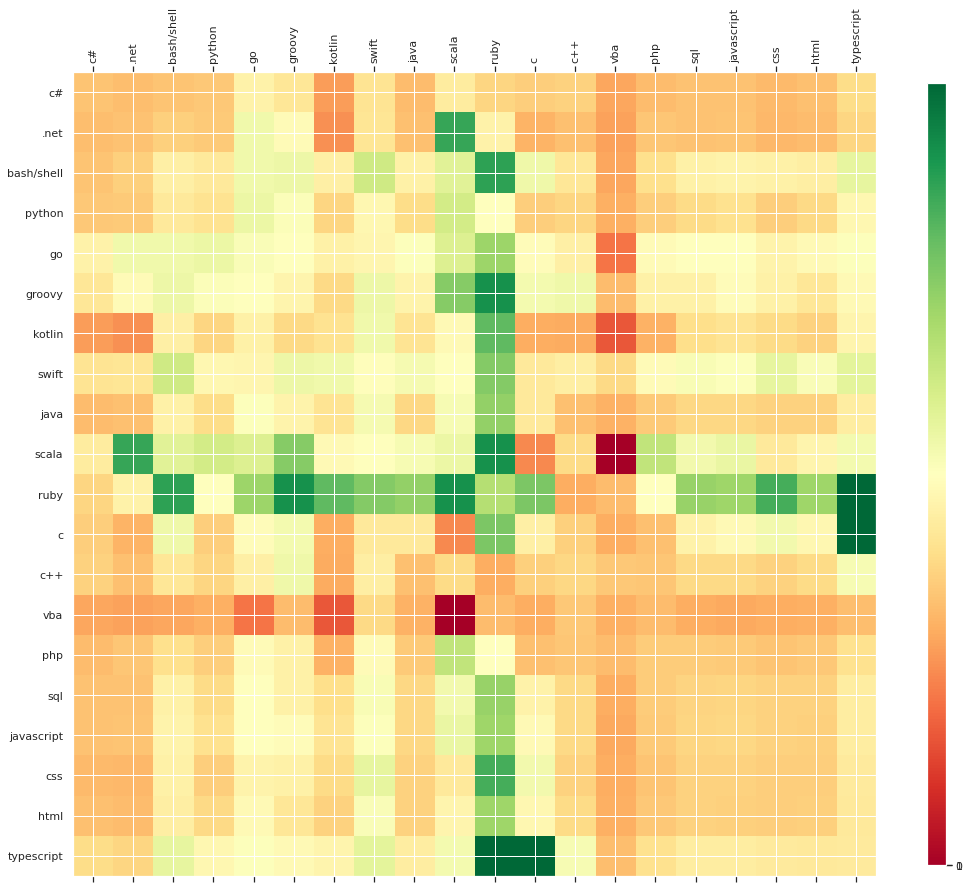

In [72]:
df_lang_space_salary = pd.DataFrame(columns = df_lang_space.columns, index = df_lang_space.columns)
for lang1 in df_lang_space_salary.columns:
  for lang2 in df_lang_space_salary.columns:
    df_lang_space_salary.loc[lang1,lang2] = df_lang_booleans[df_lang_booleans[lang1] & df_lang_booleans[lang2]]['salary_monthly_NETO'].mean()

df_lang_space_salary = df_lang_space_salary.fillna(0)
#  Plot the correlation matrix
fig, ax = plt.subplots(figsize=(18, 18))
cax = ax.matshow(df_lang_space_salary, cmap='RdYlGn')
plt.xticks(range(len(df_lang_space_salary.columns)), df_lang_space_salary.columns, rotation=90);
plt.yticks(range(len(df_lang_space_salary.columns)), df_lang_space_salary.columns);

# Add the colorbar legend
cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [73]:
df_lang2 = df_lang.copy()
df_lang2['len_langs'] = df_lang['cured_programming_languages'].str.len()
df_lang2 = df_lang2[(df_lang2['programming_language'] != 'ninguno')  ] #& (df_lang2['len_langs'] < 5)
print('POBLACIÓN POR LEN_LANGS (CANT. DE LENGUAJES QUE CONOCE)')
print(df_lang2.len_langs.value_counts())
#seaborn.countplot(df_lang2, x='len_langs')
df_lang2 = df_lang2[(df_lang2['len_langs'] < 12) & (df_lang2.programming_language.isin(pivot_df_filtered.index))]
#df_lang2.len_langs.value_counts()
df3 = df_lang2.groupby(['len_langs','programming_language']).agg({'salary_monthly_NETO':numpy.mean}).reset_index().copy()
#df3.groupby(by='len_langs')['salary_monthly_NETO'].apply(lambda grp: grp.nlargest(3))#.nlargest(3, 'salary_monthly_NETO')
df3.sort_values('salary_monthly_NETO', ascending=False, inplace=True)
df4 = df3.groupby('len_langs').head(3).copy()
df4.sort_values('len_langs', ascending=True, inplace=True)
df4


POBLACIÓN POR LEN_LANGS (CANT. DE LENGUAJES QUE CONOCE)
3     2778
5     2745
4     2680
6     2352
2     2060
7     1659
1     1051
8      928
9      522
10     250
11     219
12     144
14      84
13      65
18      36
17      34
16      32
15      30
Name: len_langs, dtype: int64


,len_langs,programming_language,salary_monthly_NETO
5,1,go,231208.72
17,1,typescript,148997.00
13,1,ruby,178889.23
34,2,scala,295199.20
33,2,ruby,145786.69
36,2,swift,185989.75
45,3,go,133640.00
54,3,scala,135705.33
53,3,ruby,154399.74
77,4,typescript,114153.87


In [74]:
df.head()

,profile_gender,profile_age,work_country,work_province,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_studies_level,profile_studies_level_state,profile_career,profile_university,profile_specialization_courses,profile_open_source_contributions,profile_programming_as_hobby,work_role,tools_platform,tools_programming_languages,tools_frameworks,tools_data_bases,tools_qa_testing,tools_IDEs,tools_work_pc_os,tools_cellphone_os,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,salary_in_usd,salary_satisfaction,salary_comparison_last_semester,salary_has_bonus,salary_bonus_tied_to,salary_inflation_adjustment_2020,salary_percentage_inflation_adjustment_2020,salary_month_last_inflation_adjustment,work_has_violence_situations,profile_sexual_orientation,profile_has_disabilities,profile_has_disabilities_hiring_difficulties,company_employee_number,company_main_activity,company_recommended,company_diversity_policies,company_extra_benefits,company_best_companies_city,cured_programming_languages
0,Mujer,26,Argentina,Ciudad Autónoma de Buenos Aires,3.00,3.00,3.00,0,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, los pagó un empleador",No,Sí,Consultant,Ninguna,Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,GNU/Linux,Android,No,0.00,Bruto,Full-Time,53000.00,43000.00,NaN,1,1,No,No recibo bono,No,0.00,0,En mi trabajo actual,Homosexual,NaN,NaN,501-1000,Servicios / Consultoría de Software / Digital,7,2,"Capacitaciones y/o cursos, Comidas pagas / sub...",NaN,[ninguno]
1,Hombre,29,Argentina,Corrientes,5.00,2.00,2.00,4,Universitario,En curso,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Developer,"Docker, Google Cloud Platform/App Engine","HTML, Javascript, Python","Django, jQuery","Informix, MySQL, PostgreSQL",Ninguna,"IPython / Jupyter, Sublime Text, Visual Studio...",GNU/Linux,Android,No,0.00,Bruto,Full-Time,79000.00,63000.00,NaN,2,2,Menos de un sueldo,Performance de la compañía,Uno,10.00,1,Jamás,Heterosexual,Visual,No,201-500,Otras industrias,8,9,"Horarios flexibles, Stock options / RSUs, Viát...",NaN,"[html, javascript, python]"
2,Mujer,22,Argentina,Ciudad Autónoma de Buenos Aires,2.00,0.00,0.00,0,Secundario,Completado,NaN,NaN,"Sí, de forma particular, Sí, los pagó un emple...",No,Sí,Infosec,"Linux, VMWare",Ninguno,Ninguno,Ninguna,Ninguna,Ninguno,Windows,iOS,No,0.00,Porcentaje de mi sueldo,Full-Time,160000.00,127000.00,NaN,3,3,Un sueldo,Performance individual,No,0.00,0,En un trabajo anterior,Bisexual o queer,NaN,No,2001-5000,Otras industrias,6,9,"Clases de gimnasia online, Comidas pagas / sub...",NaN,[ninguno]
3,Hombre,39,Argentina,Corrientes,15.00,15.00,13.00,5,Posgrado,Incompleto,Licenciatura en Sistemas,UNNE Universidad Nacional del Nordeste,"Sí, de forma particular, Sí, los pagó un emple...",Sí,Sí,SysAdmin / DevOps / SRE,"Docker, Linux, OpenStack, VMWare, Windows Server","Bash/Shell, C, CSS, HTML, Java, Javascript, PH...","jQuery, WordPress","Microsoft SQL Server, MySQL",PHPUnit,"Eclipse, Visual Studio Code",GNU/Linux,Android,"Sí, pasiva",0.00,Bruto,Full-Time,130000.00,102000.00,NaN,3,1,No,No recibo bono,No,0.00,0,En mi trabajo actual,Heterosexual,NaN,NaN,501-1000,Otras industrias,7,6,"Abono de celular, Capacitaciones y/o cursos, C...",NaN,"[bash/shell, c, css, html, java, javascript, p..."
4,Hombre,32,Argentina,Ciudad Autónoma de Buenos Aires,9.00,6.00,6.00,0,Universitario,En curso,Licenciatura en Ciencias dela Computación,UBA - Universidad de Buenos Aires,No,No,Sí,Developer,Amazon Web Services,"CSS, HTML, Javascript, SQL, TypeScript","Angular, Node.js","Amazon DynamoDB, MongoDB, MySQL",Jest,Vim,macOS,Android,No,0.00,Porcentaje de mi sueldo,Full-Time,140000.00,106000.00,NaN,1,1,Menos de un sueldo,Performance individual,No,0.00,0,Jamás,Heterosexual,NaN,NaN,11-50,Se

In [121]:
new_relevant_columns = relevant_columns + ['profile_years_experience']
new_relevant_columns.remove('tools_programming_languages')
df_lang_years = df[new_relevant_columns].copy()
ning = ['Ninguno']
df_lang_years = df_lang_years[((df_lang_years.salary_monthly_NETO / df_lang_years.salary_monthly_BRUTO) > 0.5) 
                            & ((df_lang_years.salary_monthly_NETO / df_lang_years.salary_monthly_BRUTO) < 0.9)]
lst_col = 'cured_programming_languages'
df_lang_years2 = pd.DataFrame({
                    col:numpy.repeat(df_lang_years[col].values, df_lang_years[lst_col].str.len())
                    for col in df_lang_years.columns.difference([lst_col])
                    }).assign(**{lst_col:numpy.concatenate(df_lang_years[lst_col].values)})[df_lang_years.columns.tolist()]

df_lang_years2 = df_lang_years2[df_lang_years2['cured_programming_languages'] != 'ninguno']

relevant_langs = [l for l in df_lang_years2.cured_programming_languages.value_counts().head(60).index.tolist() if l not in ['-', '/', 'no', '']]
df_lang_years2 = df_lang_years2[df_lang_years2.cured_programming_languages.isin(relevant_langs)]
bins = [0,3,6,9,12,100]
labels = ['0-3', '4-6', '7-9', '10-12', '12+']
df_lang_years2['years_experience_binned'] = pd.cut(df_lang_years2['profile_years_experience'], bins=bins, labels=labels)
df_lang_years2.years_experience_binned.value_counts()
pivoted_df2 = pd.pivot_table(df_lang_years2, values='salary_monthly_NETO', index=['years_experience_binned', 'cured_programming_languages'],
                    aggfunc=[len, numpy.mean])
pivoted_df2.reset_index(inplace=True)
pivoted_df2.columns = ['years_experience_binned','cured_programming_languages','count', 'mean_salary_NETO']
pivoted_df2.sort_values(by=['years_experience_binned','mean_salary_NETO'], ascending=[True, False], inplace=True)
pivoted_df2.groupby('years_experience_binned').head(10)

,years_experience_binned,cured_programming_languages,count,mean_salary_NETO
11,0-3,clojure,1.00,181951.00
42,0-3,terraform,1.00,97000.00
37,0-3,scala,24.00,84270.49
26,0-3,objective-c,11.00,84205.45
32,0-3,r,17.00,83691.82
24,0-3,kotlin,39.00,78091.62
41,0-3,swift,22.00,78008.36
5,0-3,bash/shell,135.00,75733.90
31,0-3,python,239.00,73689.09
19,0-3,go,56.00,73254.28
